In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Lasso,Ridge,LinearRegression,ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import NotFittedError
import os

# Load the CSV files
mf_df = pd.read_csv(r"/content/Mutual_fund Data.csv")

In [2]:
mf_df.columns

Index(['AMC', 'Fund Name', 'Morning star rating', 'Value Research rating',
       '1 month return', 'NAV', '1 Year return', '3 Year Return',
       'Minimum investment', 'Fund Manager', 'AUM', 'Category', 'Risk'],
      dtype='object')

In [3]:
mf_df.head()

,AMC,Fund Name,Morning star rating,Value Research rating,1 month return,NAV,1 Year return,3 Year Return,Minimum investment,Fund Manager,AUM,Category,Risk
0,mahindra manulife mutual fund,Mahindra Manulife Large & Mid Cap Reg-G,3,3,5.51%,28.32,37.79%,20.29%,Rs.500.0,Abhinav Khandelwal,2569.63 cr,Equity,High
1,mahindra manulife mutual fund,Mahindra Manulife Consumption Reg-G,0,3,7.25%,24.89,46.08%,21.93%,Rs.500.0,Abhinav Khandelwal,322.26 cr,Equity,High
2,mahindra manulife mutual fund,Mahindra Manulife Mid Cap Reg-G,4,4,5.94%,35.11,54.46%,27.48%,Rs.500.0,Abhinav Khandelwal,3292.76 cr,Equity,High
3,mahindra manulife mutual fund,Mahindra Manulife Small Cap Reg-G,0,0,8.37%,21.40,59.79%,0,Rs.500.0,Abhinav Khandelwal,5278.7 cr,Equity,Very High
4,mahindra manulife mutual fund,Mahindra Manulife Large Cap Reg-G,4,3,4.06%,23.69,32.07%,15.18%,Rs.500.0,Abhinav Khandelwal,577.72 cr,Equity,Very High


In [58]:
mf_df1 = mf_df.drop(columns=['Fund Name'])

In [56]:
mf_df1.dtypes

,0
AMC,object
Morning star rating,int64
Value Research rating,int64
1 month return,object
NAV,float64
1 Year return,object
3 Year Return,object
Minimum investment,object
Fund Manager,object
AUM,object


In [59]:
mf_df1["1 month return"] = pd.to_numeric(mf_df1["1 month return"].str.rstrip('%'))
mf_df1["1 Year return"] = pd.to_numeric(mf_df1["1 Year return"].str.rstrip('%'))
mf_df1["3 Year Return"] = pd.to_numeric(mf_df1["3 Year Return"].str.rstrip('%'))
mf_df1['Minimum investment'] = mf_df1['Minimum investment'].str.replace('Rs.', '', regex=False).astype(float).astype(int)
mf_df1['AUM'] = mf_df1['AUM'].str.replace('[^0-9]', '', regex=True)
mf_df1['AUM'] = pd.to_numeric(mf_df1['AUM'], errors='coerce')
mf_df1 = mf_df1.dropna(subset=['AUM'])
mf_df1['AUM'] = mf_df1['AUM'].astype(int)

In [60]:
mf_df1.head()

,AMC,Morning star rating,Value Research rating,1 month return,NAV,1 Year return,3 Year Return,Minimum investment,Fund Manager,AUM,Category,Risk,Fund_Name_Encoded
0,mahindra manulife mutual fund,3,3,5.51,28.32,37.79,20.29,500,Abhinav Khandelwal,256963,Equity,High,857
1,mahindra manulife mutual fund,0,3,7.25,24.89,46.08,21.93,500,Abhinav Khandelwal,32226,Equity,High,852
2,mahindra manulife mutual fund,4,4,5.94,35.11,54.46,27.48,500,Abhinav Khandelwal,329276,Equity,High,861
3,mahindra manulife mutual fund,0,0,8.37,21.40,59.79,0.00,500,Abhinav Khandelwal,52787,Equity,Very High,866
4,mahindra manulife mutual fund,4,3,4.06,23.69,32.07,15.18,500,Abhinav Khandelwal,57772,Equity,Very High,858


In [61]:
mf_df1.dtypes

,0
AMC,object
Morning star rating,int64
Value Research rating,int64
1 month return,float64
NAV,float64
1 Year return,float64
3 Year Return,float64
Minimum investment,int64
Fund Manager,object
AUM,int64


In [62]:
missing_fund_managers = mf_df1[mf_df1['Fund Manager'].isnull()]
missing_fund_managers

,AMC,Morning star rating,Value Research rating,1 month return,NAV,1 Year return,3 Year Return,Minimum investment,Fund Manager,AUM,Category,Risk,Fund_Name_Encoded
767,sundaram mutual fund,0,0,0.92,14.63,14.91,0.00,100,NaN,124787,Hybrid,Moderately High,1172
768,sundaram mutual fund,0,0,0.54,12.49,8.08,7.49,100,NaN,15758,Hybrid,Moderate,1185
769,sundaram mutual fund,3,0,0.00,84.14,0.00,0.00,100,NaN,195401,Hybrid,High,1184
770,sundaram mutual fund,5,3,0.29,35.87,3.29,4.69,100,NaN,314409,Debt,Low to Moderate,1199
771,sundaram mutual fund,3,0,0.00,29.30,0.00,0.00,100,NaN,36174,Debt,Low to Moderate,1207
772,sundaram mutual fund,0,0,0.00,18.11,0.00,0.00,100,NaN,3841,Other,Very High,1209
773,sundaram mutual fund,0,0,0.00,16.59,0.00,0.00,100,NaN,82843,Equity,Very High,1183
774,sundaram mutual fund,0,0,0.03,10.66,3.19,0.00,100,NaN,8334,Hybrid,Low to Moderate,1170
775,hsbc mutual fund,1,0,0.00,27.88,0.00,0.00,1000,NaN,12075,Equity,Very High,568
776,sundaram mutual fund,0,0,0.00,11.03,0.00,0.00,1000,NaN,128495,Debt,Low to Moderate,1211


In [64]:
for idx, row in missing_fund_managers.iterrows():
    amc_value = row['AMC']

    # Get a list of non-null fund managers for the same AMC
    possible_managers = mf_df1[mf_df1['AMC'] == amc_value]['Fund Manager'].dropna().unique()

    if len(possible_managers) > 0:
        # If there is at least one fund manager for the same AMC, assign the first one
        mf_df1.at[idx, 'Fund Manager'] = possible_managers[0]
    else:
        # If no fund managers are available for the AMC, leave it as NaN or assign a placeholder
        mf_df1.at[idx, 'Fund Manager'] = 'Unknown Manager'

# Check the dataframe to see if missing values are filled
print(mf_df1[mf_df1['Fund Manager'].isnull()])

Empty DataFrame
Columns: [AMC, Morning star rating, Value Research rating, 1 month return, NAV, 1 Year return, 3 Year Return, Minimum investment, Fund Manager, AUM, Category, Risk, Fund_Name_Encoded]
Index: []


In [65]:
mf_df1.head()

,AMC,Morning star rating,Value Research rating,1 month return,NAV,1 Year return,3 Year Return,Minimum investment,Fund Manager,AUM,Category,Risk,Fund_Name_Encoded
0,mahindra manulife mutual fund,3,3,5.51,28.32,37.79,20.29,500,Abhinav Khandelwal,256963,Equity,High,857
1,mahindra manulife mutual fund,0,3,7.25,24.89,46.08,21.93,500,Abhinav Khandelwal,32226,Equity,High,852
2,mahindra manulife mutual fund,4,4,5.94,35.11,54.46,27.48,500,Abhinav Khandelwal,329276,Equity,High,861
3,mahindra manulife mutual fund,0,0,8.37,21.40,59.79,0.00,500,Abhinav Khandelwal,52787,Equity,Very High,866
4,mahindra manulife mutual fund,4,3,4.06,23.69,32.07,15.18,500,Abhinav Khandelwal,57772,Equity,Very High,858


In [67]:
mf_df1.head()

,AMC,Morning star rating,Value Research rating,1 month return,NAV,1 Year return,3 Year Return,Minimum investment,Fund Manager,AUM,Category,Risk
0,mahindra manulife mutual fund,3,3,5.51,28.32,37.79,20.29,500,Abhinav Khandelwal,256963,Equity,High
1,mahindra manulife mutual fund,0,3,7.25,24.89,46.08,21.93,500,Abhinav Khandelwal,32226,Equity,High
2,mahindra manulife mutual fund,4,4,5.94,35.11,54.46,27.48,500,Abhinav Khandelwal,329276,Equity,High
3,mahindra manulife mutual fund,0,0,8.37,21.40,59.79,0.00,500,Abhinav Khandelwal,52787,Equity,Very High
4,mahindra manulife mutual fund,4,3,4.06,23.69,32.07,15.18,500,Abhinav Khandelwal,57772,Equity,Very High


In [68]:
mf_df1.dtypes

,0
AMC,object
Morning star rating,int64
Value Research rating,int64
1 month return,float64
NAV,float64
1 Year return,float64
3 Year Return,float64
Minimum investment,int64
Fund Manager,object
AUM,int64


In [70]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for column in mf_df1.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    mf_df1[column] = le.fit_transform(mf_df1[column])
    label_encoders[column] = le

mf_df1.head()

mf_df1.to_csv('mutual_fund_lb.csv', index=False)

In [72]:
for column, le in label_encoders.items():
    print(f"Mappings for {column}:")
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(mapping)
    print("\n")

Mappings for AMC:
{'360 one mutual fund': 0, 'aditya birla sun life mutual fund': 1, 'axis mutual fund': 2, 'bajaj finserv mutual fund': 3, 'bandhan mutual fund': 4, 'bank of india mutual fund': 5, 'baroda bnp paribas mutual fund': 6, 'canara robeco mutual fund': 7, 'dsp mutual fund': 8, 'edelweiss mutual fund': 9, 'franklin templeton mutual fund': 10, 'hdfc mutual fund': 11, 'hsbc mutual fund': 12, 'icici prudential mutual fund': 13, 'invesco mutual fund': 14, 'jm financial mutual fund': 15, 'kotak mahindra mutual fund': 16, 'lic mutual fund': 17, 'mahindra manulife mutual fund': 18, 'mirae asset mutual fund': 19, 'motilal oswal mutual fund': 20, 'navi mutual fund': 21, 'nippon india mutual fund': 22, 'pgim india mutual fund': 23, 'ppfas mutual fund': 24, 'quant mutual fund': 25, 'samco mutual fund': 26, 'sbi mutual fund': 27, 'sundaram mutual fund': 28, 'tata mutual fund': 29, 'taurus mutual fund': 30, 'union mutual fund': 31, 'uti mutual fund': 32, 'whiteoak capital mutual fund': 33

In [71]:
final_df = pd.read_csv("/content/mutual_fund_lb.csv")
final_df.head()

,AMC,Morning star rating,Value Research rating,1 month return,NAV,1 Year return,3 Year Return,Minimum investment,Fund Manager,AUM,Category,Risk
0,18,3,3,5.51,28.32,37.79,20.29,500,0,256963,1,1
1,18,0,3,7.25,24.89,46.08,21.93,500,0,32226,1,1
2,18,4,4,5.94,35.11,54.46,27.48,500,0,329276,1,1
3,18,0,0,8.37,21.40,59.79,0.00,500,0,52787,1,11
4,18,4,3,4.06,23.69,32.07,15.18,500,0,57772,1,11


In [73]:
X = final_df.drop(columns=['3 Year Return'])
y = final_df['3 Year Return']

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [75]:
pipelines = {
    'rf':make_pipeline(RandomForestRegressor(random_state=42)),
    'gb':make_pipeline(GradientBoostingRegressor(random_state=42)),
    'ridge':make_pipeline(Ridge(random_state=42)),
    'lasso':make_pipeline(Lasso(random_state=42)),
    'lr':make_pipeline(LinearRegression()),
    'enet':make_pipeline(ElasticNet(random_state=42))
}

In [76]:
# Providing possible values of Hyperparameter
hyperparameters = {
    'rf': {
        'randomforestregressor__min_samples_split':[2,4,6],
        'randomforestregressor__min_samples_leaf':[1,2,3]
    },
    'gb':{
        'gradientboostingregressor__alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]
    },
    'ridge':{
        'ridge__alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
    },
    'lasso':{
        'lasso__alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
    },
    'lr': {},
    'enet':{
        'elasticnet__alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]
    }
}

In [77]:
models_fit = {}
for algo, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[algo], cv=5, n_jobs=-1)
    try:
        print('Starting training for {}.'.format(algo))
        model.fit(X_train, y_train)
        models_fit[algo] = model
        print('{} has been successfully fit.'.format(algo))
    except NotFittedError as e:
        print(repr(e))

Starting training for rf.
rf has been successfully fit.
Starting training for gb.
gb has been successfully fit.
Starting training for ridge.
ridge has been successfully fit.
Starting training for lasso.
lasso has been successfully fit.
Starting training for lr.
lr has been successfully fit.
Starting training for enet.
enet has been successfully fit.



Evaluating rf
Training set errors for rf - R2: 0.9603125670597319, MAE: 0.7757392443492266, MSE: 2.896233113881744, RMSE: 1.7018322813608115
Validation set (cross-validation) mean R2 score for rf: 0.8776777994964241
Test set errors for rf - R2: 0.8947184258835834, MAE: 1.6079865187715683, MSE: 9.234302096750605, RMSE: 3.038799449906263


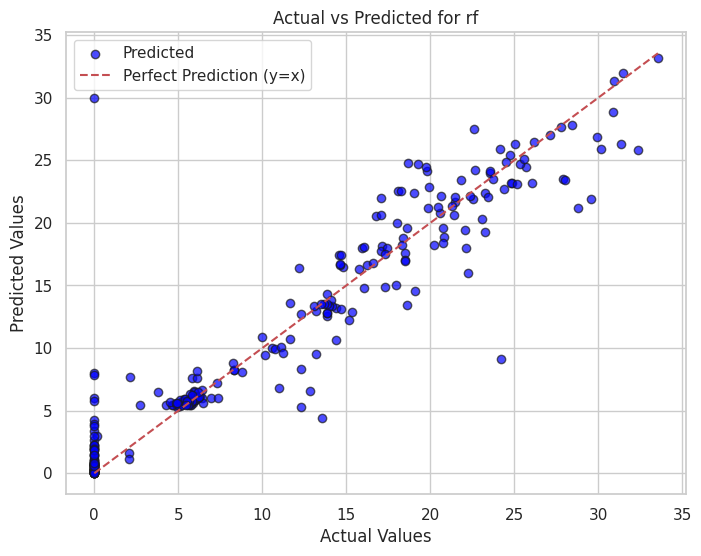


Evaluating gb
Training set errors for gb - R2: 0.9520412186086433, MAE: 1.157097655168215, MSE: 3.4998436652759817, RMSE: 1.870786910707893
Validation set (cross-validation) mean R2 score for gb: 0.8537501964828518
Test set errors for gb - R2: 0.8737522159188975, MAE: 2.017800697990393, MSE: 11.073259371683891, RMSE: 3.3276507286198007


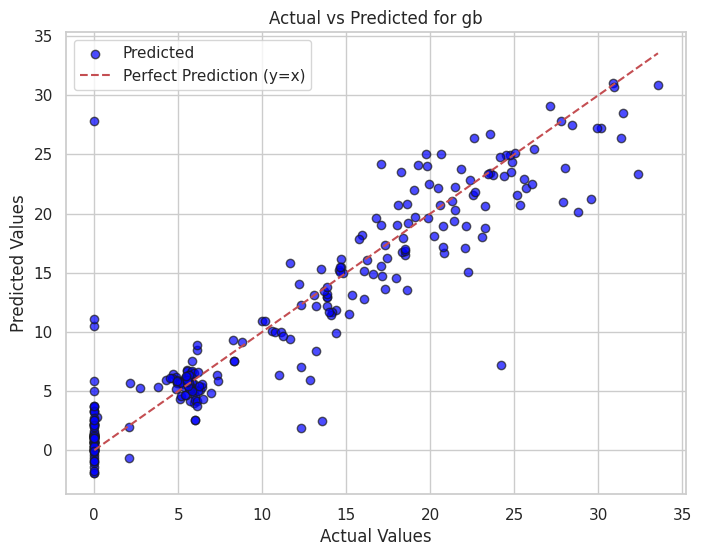


Evaluating ridge
Training set errors for ridge - R2: 0.627237129152876, MAE: 3.673562679330195, MSE: 27.202771512028402, RMSE: 5.215627623980493
Validation set (cross-validation) mean R2 score for ridge: -24.12257659655823
Test set errors for ridge - R2: 0.6466575737122344, MAE: 3.9850024981298797, MSE: 30.99184957409636, RMSE: 5.567032384861467


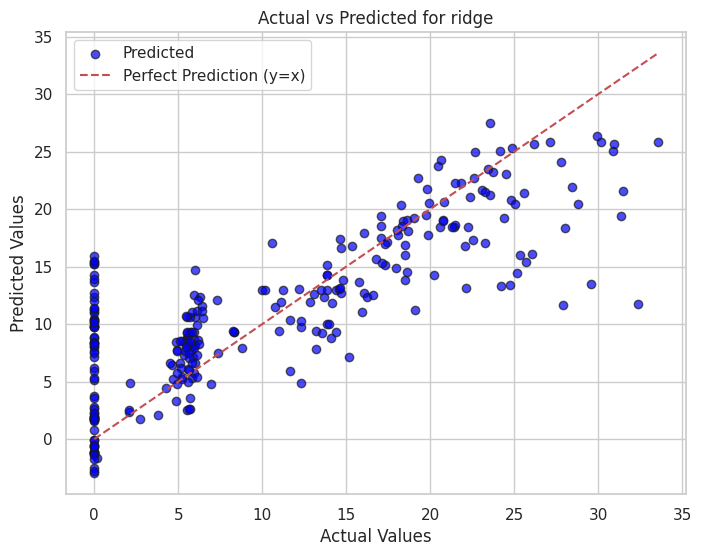


Evaluating lasso
Training set errors for lasso - R2: 0.6144055220876878, MAE: 3.6955957510374673, MSE: 28.13917184163525, RMSE: 5.304636824669079
Validation set (cross-validation) mean R2 score for lasso: -20.75809294114062
Test set errors for lasso - R2: 0.6122629379244953, MAE: 4.148701114882856, MSE: 34.0086211225583, RMSE: 5.831691103149952


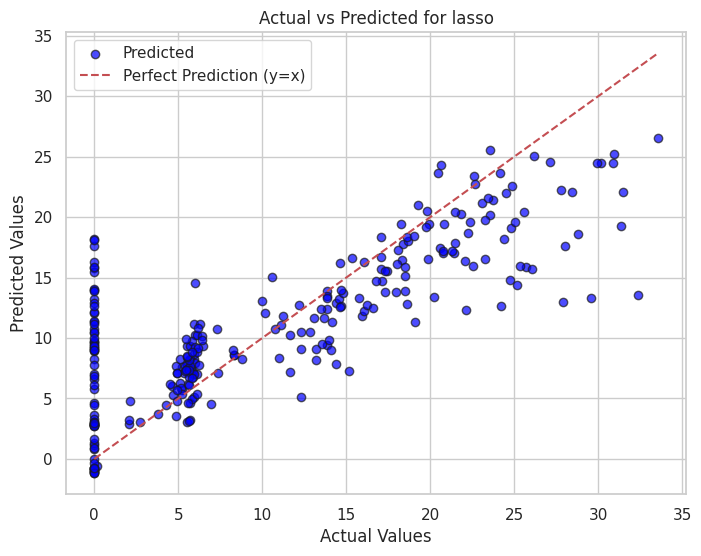


Evaluating lr
Training set errors for lr - R2: 0.6272371392428049, MAE: 3.673646224703092, MSE: 27.20277077570499, RMSE: 5.215627553392304
Validation set (cross-validation) mean R2 score for lr: -24.13057011506187
Test set errors for lr - R2: 0.6466753235091944, MAE: 3.9849984599053077, MSE: 30.990292730093394, RMSE: 5.566892556004058


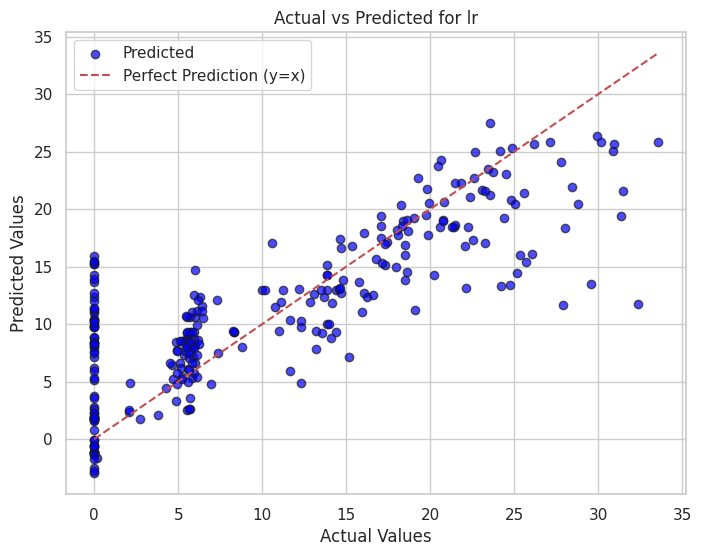


Evaluating enet
Training set errors for enet - R2: 0.6185425151523559, MAE: 3.6560289812850164, MSE: 27.83727032223429, RMSE: 5.276103706546555
Validation set (cross-validation) mean R2 score for enet: -20.31806828077043
Test set errors for enet - R2: 0.6203865546739562, MAE: 4.089867730180665, MSE: 33.296094435791666, RMSE: 5.77027680755366


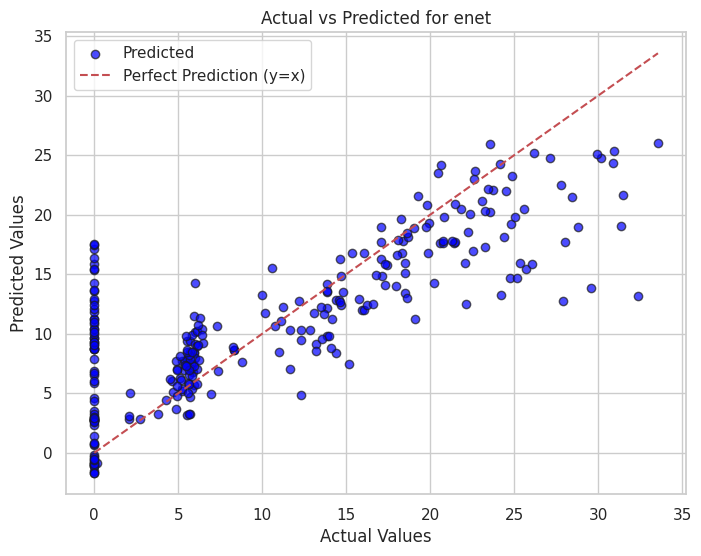

In [78]:
# Loop through and evaluate models performance on train, validation, and test sets

sns.set(style='whitegrid')
for algo, model in models_fit.items():
    print(f'\nEvaluating {algo}')

    # Training set evaluation
    yhat_train = model.predict(X_train)
    print(f'Training set errors for {algo} - R2: {r2_score(y_train, yhat_train)}, '
          f'MAE: {mean_absolute_error(y_train, yhat_train)}, '
          f'MSE: {mean_squared_error(y_train, yhat_train)}, '
          f'RMSE: {np.sqrt(mean_squared_error(y_train, yhat_train))}')

    # Validation set evaluation (average across all splits)
    mean_val_score = np.mean(model.cv_results_['mean_test_score'])
    print(f'Validation set (cross-validation) mean R2 score for {algo}: {mean_val_score}')

    # Test set evaluation
    yhat_test = model.predict(X_test)
    print(f'Test set errors for {algo} - R2: {r2_score(y_test, yhat_test)}, '
          f'MAE: {mean_absolute_error(y_test, yhat_test)}, '
          f'MSE: {mean_squared_error(y_test, yhat_test)}, '
          f'RMSE: {np.sqrt(mean_squared_error(y_test, yhat_test))}')

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, yhat_test, color='blue', edgecolor='k', alpha=0.7, label='Predicted')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Perfect Prediction (y=x)')

    plt.title(f'Actual vs Predicted for {algo}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()

    plt.show()